In [1]:
import sys

import networkx as nx
from ortools.sat.python import cp_model

from scripts import graph_osm_loader, utils, clustering, centroids_graph_builder

sys.path.append('../')

In [2]:
GRAPH_ID = 'R13470549'  # R13470549 R2555133 R3766483
# примеры id есть в graph_osm_loader.py
g = graph_osm_loader.get_graph(GRAPH_ID)
print(len(g.nodes), len(g.edges))

715 1038


In [3]:

cms_resolver = clustering.LouvainKMeansCommunityResolver(resolution=1)

t, cg = centroids_graph_builder.CentroidGraphBuilder().build_with_time(g, cms_resolver)

find centroids:   0%|          | 0/26 [00:00<?, ?it/s]

find edges:   0%|          | 0/26 [00:00<?, ?it/s]

In [4]:
N = 10
points = list({p for p, u in utils.read_points(GRAPH_ID, g, num=N)})
points

[935208512,
 5299065539,
 1585803366,
 2383149582,
 3881490992,
 1576825011,
 5316635926,
 4843964790,
 5271556249,
 2027953694]

In [5]:
dst = {(u, v): nx.dijkstra_path_length(g, u, v, weight='length') for u in points for v in points}

In [7]:
def get_model(points, dst_matrix, START = None, cms_order = None, initial_X = None, initial_U = None):
    if START is None:
        START = points[0]

    X = {}
    U = {}
    model = cp_model.CpModel()

    for v in points:
        for u in points:
            X[v, u] = model.new_bool_var(f'r_{v}_{u}')
        model.add(X[v, v] == 0)
        U[v] = model.new_int_var(name=f'u_{v}', lb=0, ub=N-1)

    for u in points:
        model.add(sum(X[u, v] for v in points) == sum(X[v, u] for v in points))

    for u in points:
        if u == START:
            pass
        else:
            model.add(sum(X[v, u] for v in points) == 1)

    model.add(sum(X[START, v] for v in points if v != START) == 1)
    U[START] = 0
    for u in points:
        for v in points:
            if v != START:
                model.add(U[u] + 1 <= U[v] + (1 - X[u, v]) * 1000)
    
    if cms_order is not None:
        vals = list(cms_order.items())
        vals.sort(key=lambda x: x[1])
        for i in range(len(vals)-2):
            (k1, v1) = vals[i]
            (k2, v2) = vals[i+2]
            if v1 == 0 or v1 == len(vals) - 1:
                continue
            set1 = set()
            set2 = set()
            for u in points:
                if g.nodes()[u]['cluster'] == k2:
                    set2.add(u)
                elif g.nodes()[u]['cluster'] == k1:
                    set1.add(u)
            print(set1,set2)
            print(k1,k2)
            for u in set1:
                for v in set2:
                    model.add(U[u]<=U[v])
    
    if initial_X is not None:
        for (u,v),val in initial_X.items():
            model.add_hint(X[u,v],val)
    if initial_U is not None:
        for u,val in initial_U.items():
            model.add_hint(U[u],val)
    
    
    obj = sum(X[a, b] * int(dst_matrix[a, b]) for a in points for b in points)
    model.minimize(obj)
    return model, X, U

In [8]:
cms_points = list({g.nodes()[p]['cluster'] for p in points})
cms_dst = {(u, v): nx.dijkstra_path_length(cg.g, u, v, weight='length') for u in cms_points for v in cms_points}

In [10]:
# from cpsat_autotune import  tune_time_to_optimal, tune_for_gap_within_timelimit
# model, X = get_model_1()
# best = tune_time_to_optimal(
#     model,
#     max_time_in_seconds=5,  # Enter a time limit slightly above what the solver with default parameters needs
#     n_samples_for_trial=10,  # Number of samples for each trial
#     n_samples_for_verification=10,  # Number of samples for each statistically relevant comparison.
#     n_trials=40,  # Number of trials to run with Optuna
#     # relative_gap_limit= 10e5
# )

In [11]:
best = {'preferred_variable_order': 2,
        'clause_cleanup_protection': 1,
        'max_presolve_iterations': 5,
        'cp_model_probing_level': 1,
        'presolve_probing_deterministic_time_limit': 10.0,
        'search_branching': 2,
        'feasibility_jump_linearization_level': 0,
        'fp_rounding': 0,
        'polish_lp_solution': True,
        'linearization_level': 0,
        'cut_level': 2,
        'max_all_diff_cut_size': 128,
        'symmetry_level': 0,
        'num_workers': 8}
solver = cp_model.CpSolver()

for k, v in best.items():
    if isinstance(v, list):
        for ss in v:
            solver.parameters.ignore_subsolvers.append(ss)
    else:
        if 'ignore_subsolvers' in k:
            if v:
                solver.parameters.ignore_subsolvers.append(k.split(':')[1])
        else:
            exec(f'solver.parameters.{k} = {v}')

solver.parameters.log_search_progress = True
solver.parameters.max_time_in_seconds = 60.0 * 30

In [12]:
START = points[0]

In [13]:
model, X, U = get_model(cms_points, cms_dst, START=g.nodes()[START]['cluster'])
status = solver.solve(model)
status


Starting CP-SAT solver v9.12.4544
Parameters: preferred_variable_order: IN_RANDOM_ORDER max_time_in_seconds: 1800 log_search_progress: true presolve_probing_deterministic_time_limit: 10 clause_cleanup_protection: PROTECTION_ALWAYS search_branching: PORTFOLIO_SEARCH linearization_level: 0 cp_model_probing_level: 1 max_presolve_iterations: 5 max_all_diff_cut_size: 128 fp_rounding: NEAREST_INTEGER polish_lp_solution: true symmetry_level: 0 cut_level: 2 num_workers: 8 feasibility_jump_linearization_level: 0

Initial optimization model '': (model_fingerprint: 0x24ecba331d63b50)
#Variables: 72 (#bools: 56 in objective)
  - 64 Booleans in [0,1]
  - 8 in [0,9]
#kLinear1: 15
#kLinear2: 7
#kLinear3: 42
#kLinearN: 16 (#terms: 175)

Starting presolve at 0.00s
  3.04e-05s  0.00e+00d  [DetectDominanceRelations] 
  2.80e-04s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  6.70e-06s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=8 
  1.84e-05s  0.00e+00d  [Det

4

In [14]:
# objective: 39792
# best_bound: 39792

In [15]:
order_cms = {c: solver.value(U[c]) for c in U}
order_cms

{0: 0, 2: 7, 5: 4, 7: 1, 8: 2, 16: 3, 20: 5, 24: 6}

In [16]:
model, X, U = get_model(points, dst, cms_order=order_cms, START = START)
status = solver.solve(model)
status

{2027953694} {5299065539}
7 16
{1576825011} {4843964790}
8 5
{5299065539} {3881490992}
16 20
{4843964790} {2383149582, 5316635926}
5 24
{3881490992} {5271556249, 1585803366}
20 2

Starting CP-SAT solver v9.12.4544
Parameters: preferred_variable_order: IN_RANDOM_ORDER max_time_in_seconds: 1800 log_search_progress: true presolve_probing_deterministic_time_limit: 10 clause_cleanup_protection: PROTECTION_ALWAYS search_branching: PORTFOLIO_SEARCH linearization_level: 0 cp_model_probing_level: 1 max_presolve_iterations: 5 max_all_diff_cut_size: 128 fp_rounding: NEAREST_INTEGER polish_lp_solution: true symmetry_level: 0 cut_level: 2 num_workers: 8 feasibility_jump_linearization_level: 0

Initial optimization model '': (model_fingerprint: 0x95df699f1db516d9)
#Variables: 110 (#bools: 90 in objective)
  - 100 Booleans in [0,1]
  - 10 in [0,9]
#kLinear1: 19
#kLinear2: 16
#kLinear3: 72
#kLinearN: 20 (#terms: 279)

Starting presolve at 0.00s
  4.61e-05s  0.00e+00d  [DetectDominanceRelations] 
  5.7

4

In [17]:
x_sol = {(u,v) : solver.value(val) for (u,v),val in X.items()}
u_sol = {u : solver.value(val) for u,val in U.items()}

In [18]:
model, X, U = get_model(points, dst, START = START, initial_X=x_sol)
status = solver.solve(model)
status


Starting CP-SAT solver v9.12.4544
Parameters: preferred_variable_order: IN_RANDOM_ORDER max_time_in_seconds: 1800 log_search_progress: true presolve_probing_deterministic_time_limit: 10 clause_cleanup_protection: PROTECTION_ALWAYS search_branching: PORTFOLIO_SEARCH linearization_level: 0 cp_model_probing_level: 1 max_presolve_iterations: 5 max_all_diff_cut_size: 128 fp_rounding: NEAREST_INTEGER polish_lp_solution: true symmetry_level: 0 cut_level: 2 num_workers: 8 feasibility_jump_linearization_level: 0

Initial optimization model '': (model_fingerprint: 0x828ef4b46e442023)
#Variables: 110 (#bools: 90 in objective)
  - 100 Booleans in [0,1]
  - 10 in [0,9]
#kLinear1: 19
#kLinear2: 9
#kLinear3: 72
#kLinearN: 20 (#terms: 279)

Starting presolve at 0.00s
The solution hint is incomplete: 100 out of 110 non fixed variables hinted.
  3.05e-05s  0.00e+00d  [DetectDominanceRelations] 
  3.01e-04s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  3.86e-06s  0.00e+00d  

4

In [19]:
model, X, U = get_model(points, dst, START = START)
status = solver.solve(model)
status


Starting CP-SAT solver v9.12.4544
Parameters: preferred_variable_order: IN_RANDOM_ORDER max_time_in_seconds: 1800 log_search_progress: true presolve_probing_deterministic_time_limit: 10 clause_cleanup_protection: PROTECTION_ALWAYS search_branching: PORTFOLIO_SEARCH linearization_level: 0 cp_model_probing_level: 1 max_presolve_iterations: 5 max_all_diff_cut_size: 128 fp_rounding: NEAREST_INTEGER polish_lp_solution: true symmetry_level: 0 cut_level: 2 num_workers: 8 feasibility_jump_linearization_level: 0

Initial optimization model '': (model_fingerprint: 0x28760fa4a79bde65)
#Variables: 110 (#bools: 90 in objective)
  - 100 Booleans in [0,1]
  - 10 in [0,9]
#kLinear1: 19
#kLinear2: 9
#kLinear3: 72
#kLinearN: 20 (#terms: 279)

Starting presolve at 0.00s
  3.02e-05s  0.00e+00d  [DetectDominanceRelations] 
  2.96e-04s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  4.05e-06s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=10 
  1.93e-05s  0.00e+00d 

4

In [32]:
model = get_model(points, dst,START = START)
status = solver.solve(model)
status


Starting CP-SAT solver v9.12.4544
Parameters: preferred_variable_order: IN_RANDOM_ORDER max_time_in_seconds: 1800 log_search_progress: true presolve_probing_deterministic_time_limit: 10 clause_cleanup_protection: PROTECTION_ALWAYS search_branching: PORTFOLIO_SEARCH linearization_level: 0 cp_model_probing_level: 1 max_presolve_iterations: 5 max_all_diff_cut_size: 128 fp_rounding: NEAREST_INTEGER polish_lp_solution: true symmetry_level: 0 cut_level: 2 num_workers: 8 feasibility_jump_linearization_level: 0

Initial optimization model '': (model_fingerprint: 0x2e4e141749a2d859)
#Variables: 210 (#bools: 90 in objective)
  - 210 Booleans in [0,1]
#kLinear1: 10
#kLinear3: 1'800
#kLinearN: 20 (#terms: 207)

Starting presolve at 0.00s
  9.60e-05s  0.00e+00d  [DetectDominanceRelations] 
  1.87e-03s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  4.60e-06s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=18 
[SAT presolve] num removable Booleans: 2 / 182
[S

3

In [22]:
# точное решения для 50 точек
# objective: 51523
# best_bound: 51523
# walltime: 88.2413
# usertime: 88.2413

In [23]:
# кластерное решение для 50 точек
# objective: 51524
# best_bound: 51524
# walltime: 3.20884
# usertime: 3.20884

In [24]:
# objective: 33237
# best_bound: 33237

# objective: 33734
# best_bound: 33734

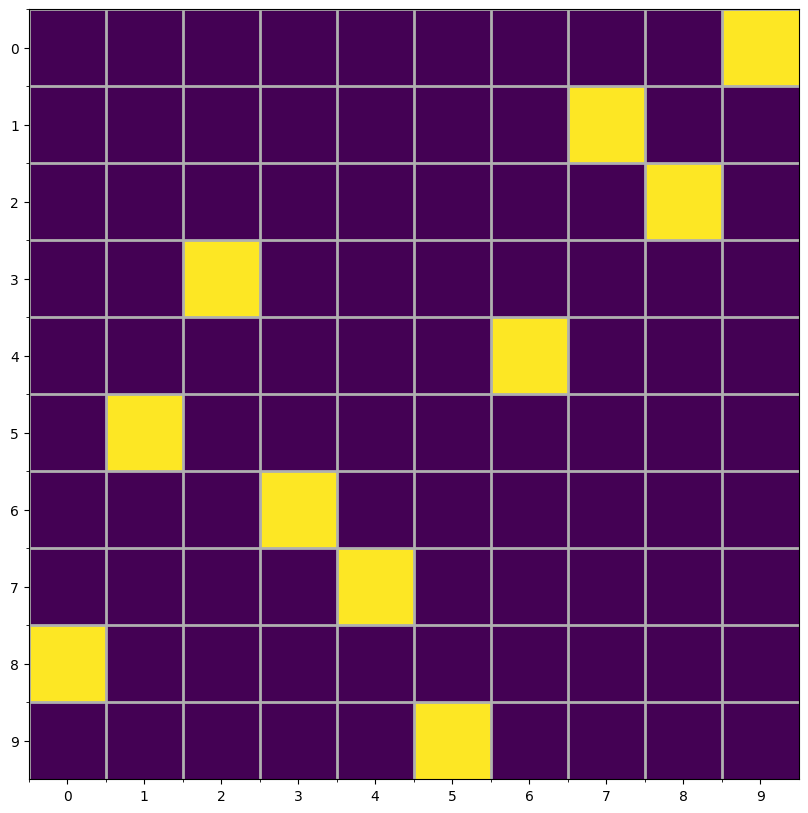

In [25]:
res = {}
u = points[0]
for i in range(len(points) + 1):
    res[i] = u
    u = [v for v in points if solver.value(X[u, v]) == 1][0]

In [26]:
import matplotlib.pyplot as plt
import numpy as np

rr = {(u, v): solver.value(X[u, v]) for u, v in X}
node2id = {u: i for i, u in enumerate(points)}
x = np.zeros((len(points), len(points)))
for (u, v) in rr:
    x[node2id[u], node2id[v]] = rr[u, v]
_, _ = plt.subplots(1, 1, figsize=(
10, 10))  # nx.draw(g, pos= {u : [d['x'],d['y']] for u,d in g.nodes(data=True)}, node_size= 20)

plt.imshow(x)
plt.xticks([i for i in range(N)], [i for i in range(N)])
plt.yticks([i for i in range(N)], [i for i in range(N)])
ax = plt.gca()
ax.set_xticks([x - 0.5 for x in range(N)], minor=True)
ax.set_yticks([y - 0.5 for y in range(N)], minor=True)
plt.grid(which="minor", ls="-", lw=2)
plt.show()

In [27]:
# res = {r : u for (r,u),v in routes.items() if solver.value(v) == 1 }
# res

In [28]:
subgraph = nx.DiGraph()

1483.0770000000002
2694.4370000000004
1823.808
1440.1060000000002
3107.722
7166.543
512.433
2459.141
938.876
3296.474


In [29]:
pp = [res[i] for i in range(len(points) + 1)]
subgraph_points = set(pp)
L = 0
for i in range(len(pp) - 1):
    p1, p2 = res[i], res[i + 1]
    l, path = nx.single_source_dijkstra(g, p1, p2, weight='length')
    L += l
    print(l)
    for j in range(len(path) - 1):
        u1, u2 = path[j], path[j + 1]
        subgraph.add_edge(u1, u2)
    subgraph_points.update(path)
# subgraph = g.subgraph(subgraph_points)

np.float64(24922.617)

In [30]:
L

In [31]:
node_colors = ['red' if u in set(res.values()) else 'green' for u in subgraph.nodes()]

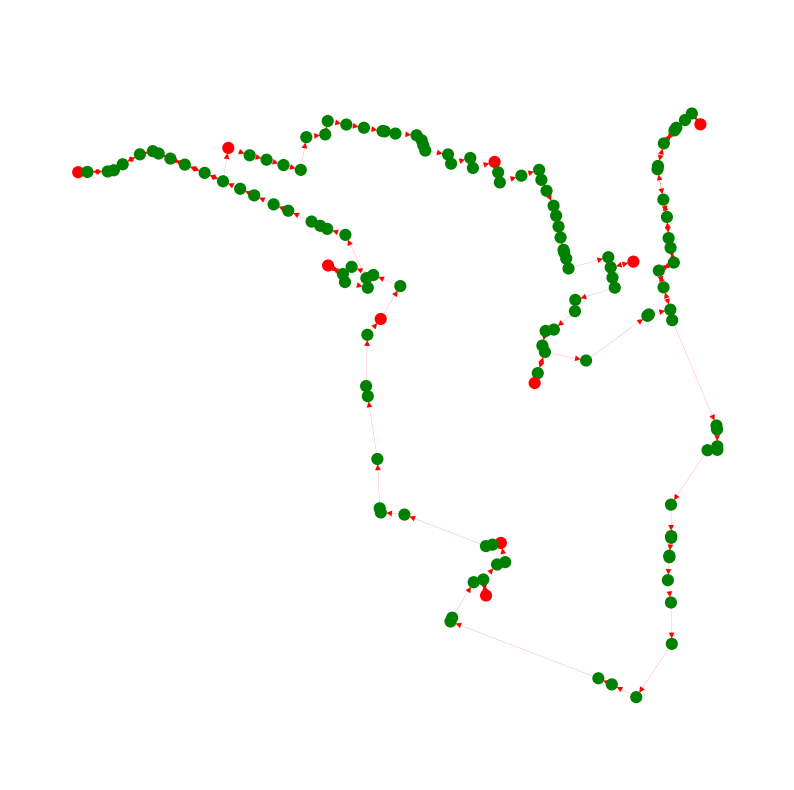

In [32]:
# labeldict = {u : u for u in res.values()}

In [ ]:
from matplotlib import pyplot as plt

_, _ = plt.subplots(1, 1, figsize=(
10, 10))  # nx.draw(g, pos= {u : [d['x'],d['y']] for u,d in g.nodes(data=True)}, node_size= 20)
nx.draw(subgraph, pos={u: [d['x'], d['y']] for u, d in g.nodes(data=True)}, node_size=60, node_color=node_colors,
        edge_color='red', width=0.1)

In [ ]:
from matplotlib import pyplot as plt

_, _ = plt.subplots(1, 1, figsize=(
10, 10))  # nx.draw(g, pos= {u : [d['x'],d['y']] for u,d in g.nodes(data=True)}, node_size= 20)
nx.draw(subgraph, pos={u: [d['x'], d['y']] for u, d in g.nodes(data=True)}, node_size=60, node_color=node_colors,
        edge_color='red', width=0.1)